# Import libs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

%matplotlib inline

# Reading Data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# First exploratoty analysis

In [3]:
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


In [4]:
train.head(1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500


In [5]:
test.head(1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal


In [6]:
# Saving the Id
train_ID = train['Id']
test_ID = test['Id']

# Droping the Id
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

## Outlier analysis

Text(0.5, 0, 'GrLivArea')

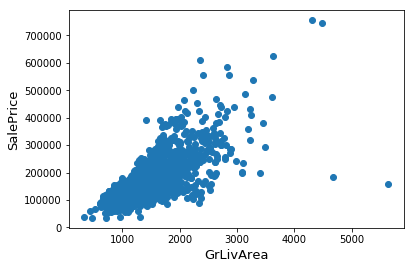

In [7]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)

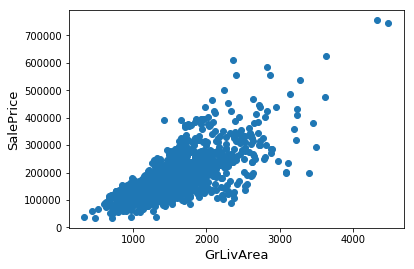

In [8]:
# Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

# Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

# Now it's great!


 mu = 180932.92 and sigma = 79467.79



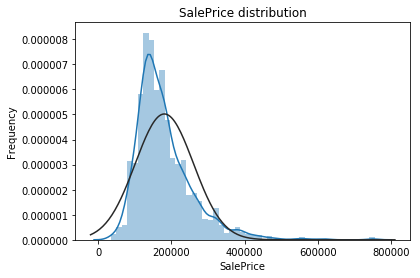

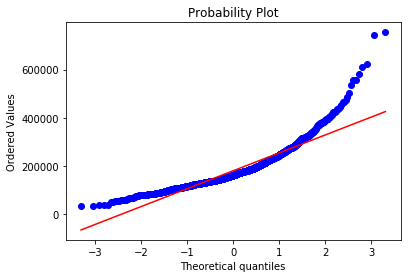

In [9]:
sns.distplot(train['SalePrice'] , fit=norm);
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Ploting the distribution
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# Getting also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()


 mu = 12.02 and sigma = 0.40



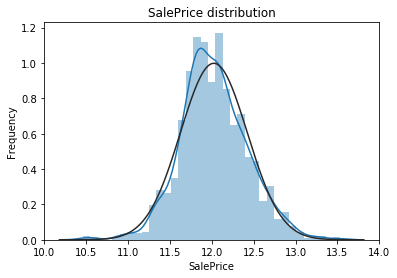

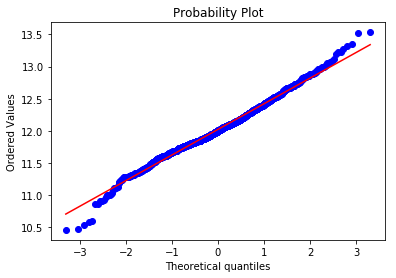

In [10]:
# We use the numpy fuction log1p which applies log(1+x) to all elements of the column
train['SalePrice'] = np.log1p(train['SalePrice'])

#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

## Feature engineering

In [11]:
ntrain = train.shape[0]
ntest = test.shape[0]

y_train = train['SalePrice']

all_data = pd.concat([train.drop(['SalePrice'], axis = 1), test]).reset_index(drop = True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


### Missing data

In [12]:
# Is there data missing? If yes, a lot?
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:20]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageFinish,5.450806
GarageYrBlt,5.450806
GarageQual,5.450806
GarageCond,5.450806


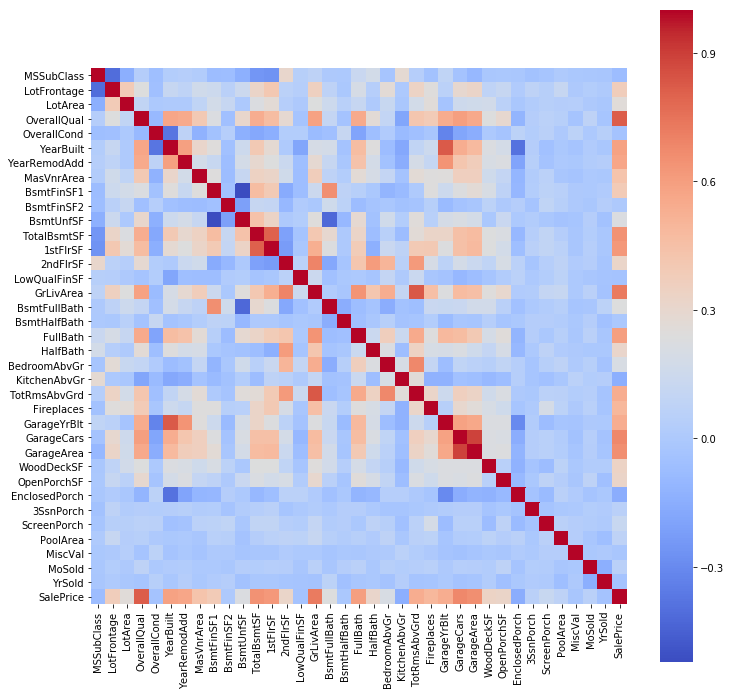

In [13]:
# Letś the feature correlation
plt.subplots(figsize=(12,12))
sns.heatmap(train.corr(), square=True, cmap = 'coolwarm')

In [14]:
# PoolQC : data description says NA means 'No Pool'. That make sense,
# given the huge ratio of missing value (+99%) and majority of houses have no Pool at all in general.
all_data['PoolQC'] = all_data['PoolQC'].fillna('None')

In [15]:
# MiscFeature : data description says NA means "no misc feature"
all_data['MiscFeature'] = all_data['MiscFeature'].fillna('None')

In [16]:
# Alley : data description says NA means 'no alley access'
all_data['Alley'] = all_data['Alley'].fillna('None')

In [17]:
# Fence: data description says NA means 'no fence'
all_data['Fence'] = all_data['Fence'].fillna('None')

In [18]:
# FirepaceQu: data description says NA means 'no fireplace'
all_data['FireplaceQu'] = all_data['FireplaceQu'].fillna('None')

In [19]:
# LotFrontage : Since the area of each street connected to the house property most likely 
# have a similar area to other houses in its neighborhood, we can fill in missing values 
# by the median LotFrontage of the neighborhood.

all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median()))

In [20]:
# GarageType, GarageFinish, GarageQual and GarageCond : Replacing missing data with None
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

In [21]:
# GarageYrBlt, GarageArea and GarageCars : Replacing missing data with 0 
# Since No garage = no cars in such garage.
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

In [22]:
# BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath: 
# missing values are likely zero for having no basement
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

In [23]:
# BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2 : 
# For all these categorical basement-related features, NaN means that there is no basement.
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

In [24]:
# MasVnrArea and MasVnrType : NA most likely means no masonry veneer for these houses. 
# We can fill 0 for the area and None for the type.
all_data['MasVnrType'] = all_data['MasVnrType'].fillna('None')
all_data['MasVnrArea'] = all_data['MasVnrArea'].fillna(0)

In [25]:
# MSZoning (The general zoning classification) : 'RL' is by far the most common value.
# So we can fill in missing values with 'RL'
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

In [26]:
# Utilities : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . 
# Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. 
# We can then safely remove it.
all_data = all_data.drop(['Utilities'], axis=1)

In [27]:
# Functional : data description says NA means typical
all_data['Functional'] = all_data['Functional'].fillna('Typ')

In [28]:
# Electrical : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

In [29]:
# KitchenQual: Only one NA value, and same as Electrical, we set 'TA' 
# (which is the most frequent) for the missing value in KitchenQual.
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

In [30]:
# Exterior1st and Exterior2nd : Again Both Exterior 1 & 2 have only one missing value. 
# We will just substitute in the most common string
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

In [31]:
# SaleType : Fill in again with most frequent which is 'WD'
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

In [32]:
# MSSubClass : Na most likely means No building class. We can replace missing values with None
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [33]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


### Converting numerical features to categorical

In [34]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [35]:
# Encoding some categorical data
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

In [36]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

### Skewed features

In [37]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)

,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


In [38]:
 # Cox Box transformation
skewness = skewness[abs(skewness) > 0.75]

skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)

In [39]:
# Making all the variables dummies 
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 220)


In [40]:
# Getting the train and test set back
train = all_data[:ntrain]
test = all_data[ntrain:]

In [41]:
train.head(5)

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,2.885846,5.831328,19.212182,0.730463,0.730463,1.540963,0.0,2.440268,1.820334,14.187527,...,0,0,0,1,0,0,0,0,1,0
1,2.055642,6.221214,19.712205,0.730463,0.730463,1.540963,0.0,2.259674,2.440268,14.145138,...,0,0,0,1,0,0,0,0,1,0
2,2.885846,5.914940,20.347241,0.730463,0.730463,0.000000,0.0,2.440268,1.820334,14.184404,...,0,0,0,1,0,0,0,0,1,0
3,3.011340,5.684507,19.691553,0.730463,0.730463,0.000000,0.0,2.440268,1.820334,14.047529,...,0,0,0,1,1,0,0,0,0,0
4,2.885846,6.314735,21.325160,0.730463,0.730463,0.000000,0.0,2.602594,1.820334,14.182841,...,0,0,0,1,0,0,0,0,1,0


# Classifiers

In [42]:
# Evaluation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

### LASSO Regression

In [43]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
print("\nLasso score: {:.4f} ({:.4f})\n".format(rmsle_cv(lasso).mean(), rmsle_cv(lasso).std()))


Lasso score: 0.1115 (0.0074)



### Elatic Net Regression

In [44]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
print("ElasticNet score: {:.4f} ({:.4f})\n".format(rmsle_cv(ENet).mean(), rmsle_cv(ENet).std()))

ElasticNet score: 0.1116 (0.0074)



### Kernel Ridge Regression

In [45]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(rmsle_cv(KRR).mean(), rmsle_cv(KRR).std()))

Kernel Ridge score: 0.1153 (0.0075)



### Gradient Boosting Regression

In [46]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(rmsle_cv(GBoost).mean(), rmsle_cv(GBoost).std()))

Gradient Boosting score: 0.1168 (0.0083)



### XGBoost

In [47]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
print("Xgboost score: {:.4f} ({:.4f})\n".format(rmsle_cv(model_xgb).mean(), rmsle_cv(model_xgb).std()))

Xgboost score: 0.1155 (0.0075)



### LightGBM

In [48]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
print("LGBM score: {:.4f} ({:.4f})\n" .format(rmsle_cv(model_lgb).mean(), rmsle_cv(model_lgb).std()))

LGBM score: 0.1163 (0.0064)



## Averaging models

In [49]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [50]:
# ENet, GBoost, KRR and lasso are averaged
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

print(" Averaged base models score: {:.4f} ({:.4f})\n".format(rmsle_cv(averaged_models).mean(), rmsle_cv(averaged_models).std()))

 Averaged base models score: 0.1087 (0.0077)



## Ensambling

In [51]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [53]:
averaged_models.fit(train, y_train)
averaged_models_train_pred = averaged_models.predict(train)
averaged_models_pred = averaged_models.predict(test)
print(rmsle(y_train, averaged_models_train_pred))

0.07940238652407113


In [54]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

0.07871618513843127


In [55]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

0.07225550554834881


## Final Ensambling

In [56]:
# RMSE on the entire Train data when averaging
print('RMSLE score on train data:')
print(rmsle(y_train,averaged_models_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

RMSLE score on train data:
0.07605099869811038


In [57]:
ensemble = averaged_models_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

# Submission

In [58]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)